<h1 align="center">3.1 Feature Engeneering (Shops)</h1>
<h3 align="center">Dataset: <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Predict future sales</a></h3>

### Imports

In [ ]:
!pip install mpl_toolkits.basemap

ERROR: Could not find a version that satisfies the requirement mpl_toolkits.basemap (from versions: none)
ERROR: No matching distribution found for mpl_toolkits.basemap
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install mpl_toolkits.basemap

ERROR: Could not find a version that satisfies the requirement mpl_toolkits.basemap (from versions: none)
ERROR: No matching distribution found for mpl_toolkits.basemap
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim # pacman -S python-geopy
from mpl_toolkits.basemap import Basemap # pacman -S python-basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

### Constants

In [ ]:
ENGLISH = True

DATA_RUS_PATH = "../DATA/1. Original data Russian (96Mb)/"
DATA_ENG_PATH = "../DATA/2. Translated data English (1Mb)/"
DATA_FE_PATH  = "../DATA/3. Feature Engeneering/"
DATA_SUB_PATH = "../DATA/5. Submissions/"


### Load data

In [ ]:
sales = pd.read_csv(DATA_RUS_PATH + "sales_train.csv")          # Dayly sales  Jan 2013 -> Oct 2015
test  = pd.read_csv(DATA_RUS_PATH + "test.csv", index_col="ID") # Predict Noviember 2015
sub   = pd.read_csv(DATA_RUS_PATH + "sample_submission.csv", index_col="ID")

if ENGLISH: 
    shops = pd.read_csv(DATA_ENG_PATH + "shops.csv", index_col="shop_id") # shops    (60)
    items = pd.read_csv(DATA_ENG_PATH + "items.csv")           # products  (22170)
    cats  = pd.read_csv(DATA_ENG_PATH + "item_categories.csv") # product categories (84)

else:
    shops = pd.read_csv(DATA_RUS_PATH + "shops.csv", index_col="shop_id")           # shops    (60)
    items = pd.read_csv(DATA_RUS_PATH + "items.csv")           # products  (22170)
    cats  = pd.read_csv(DATA_RUS_PATH + "item_categories.csv") # product categories (84)

### Shops

In [ ]:
shops.head(5)

,shop_name
shop_id,
0,yakutsk ordzhonikidze - 56 francs
1,yakutsk tc central fran
2,adygea tc mega
3,balashikha tc oktyabr-kinomir
4,volga tc volga mall


### Lowercase

In [ ]:
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')
shops.head(5)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,shop_name
shop_id,
0,yakutsk ordzhonikidze 56 francs
1,yakutsk tc central fran
2,adygea tc mega
3,balashikha tc oktyabr kinomir
4,volga tc volga mall


### Shop type

In [ ]:
"""
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'МТРЦ' if 'МТРЦ' in x
                                              else 'ТРЦ' if 'ТРЦ' in x
                                              else 'ТРК' if 'ТРК' in x
                                              else 'ТЦ' if 'ТЦ' in x
                                              else 'ТК' if 'ТК' in x
                                              else 'NO_DATA')
""";

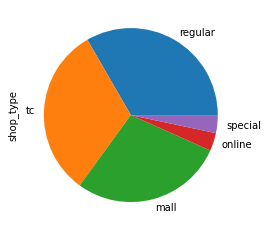

In [ ]:
shops['shop_type'] = 'regular' # By default all shops are regular shops

#there is some overlap in tc and mall, mall is given precedence
shops.loc[ shops['shop_name'].str.contains(r'tc'), 'shop_type' ]               = 'tc'
shops.loc[ shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type' ] = 'mall'
shops.loc[ shops.index.isin([9,20]), 'shop_type' ]                             = 'special'
shops.loc[ shops.index.isin([12,55]), 'shop_type' ]                            = 'online'

shops['shop_type'].value_counts().plot.pie();

### Shop city

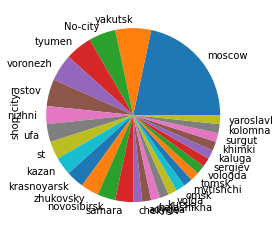

In [ ]:
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops.index.isin([9,12,55]), 'shop_city'] = 'No-city'

shops['shop_city'].value_counts().plot.pie();

### Latitude & Longitude

In [ ]:
cities = pd.DataFrame(shops['shop_city'].unique(), columns=["shop_city"])
shops['shop_city'].unique()

array(['yakutsk', 'adygea', 'balashikha', 'volga', 'vologda', 'voronezh',
       'No-city', 'zhukovsky', 'kazan', 'kaluga', 'kolomna',
       'krasnoyarsk', 'kursk', 'moscow', 'mytishchi', 'nizhni',
       'novosibirsk', 'omsk', 'rostov', 'st', 'samara', 'sergiev',
       'surgut', 'tomsk', 'tyumen', 'ufa', 'khimki', 'chekhov',
       'yaroslavl'], dtype=object)

In [ ]:
def add_lat_lon(df):

    city = df["shop_city"]
    
    if city=="No-city":
        df['latitude']  = 0
        df['longitude'] = 0
        
    else:
        country ="Ru"
        geolocator = Nominatim(user_agent="my_user_agent")
        loc = geolocator.geocode(city+','+ country)
    
        if loc != None:
            df['latitude'] = loc.latitude
            df['longitude'] = loc.longitude
            
    return df

cities = cities.apply(add_lat_lon, axis=1)

In [ ]:
cities

,shop_city,latitude,longitude
0,yakutsk,62.027287,129.732086
1,adygea,44.693901,40.152042
2,balashikha,55.803623,37.964649
3,volga,56.167024,44.215057
4,vologda,59.218876,39.893276
5,voronezh,51.660598,39.200586
6,No-city,0.000000,0.000000
7,zhukovsky,55.597280,38.119986
8,kazan,55.782355,49.124227
9,kaluga,54.510109,36.259811


In [ ]:
fig = plt.figure(figsize=(14, 7))
m = Basemap(projection='lcc', resolution=None,
            width=6E6, height=3E6, 
            lon_0=75, lat_0=60)

m.etopo(scale=0.5, alpha=0.5)

for index, row in cities.iterrows():
    city_name = row["shop_city"]
    if city_name=="No-city": continue
    city_lat  = row["latitude"]
    city_lon  = row["longitude"]
    
    x, y = m(city_lon, city_lat) # Map (long, lat) to (x, y) for plotting
    plt.plot(x, y, 'ok', markersize=4)
    plt.text(x, y, city_name, fontsize=10);

NameError: name 'Basemap' is not defined

<Figure size 1008x504 with 0 Axes>

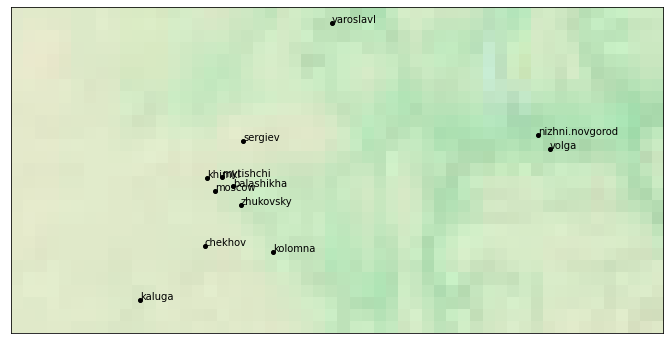

In [ ]:
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='lcc', resolution=None,
            width=0.8E6, height=0.4E6, 
            lon_0=40, lat_0=56)

m.etopo(scale=0.5, alpha=0.5)

for index, row in cities.iterrows():
    city_name = row["shop_city"]
    city_lat  = row["latitude"]
    city_lon  = row["longitude"]
    
    if city_name=="No-city": continue
    if city_lon<31 or 45<city_lon: continue
    if city_lat<54 or 59<city_lat: continue
    
    x, y = m(city_lon, city_lat) # Map (long, lat) to (x, y) for plotting
    plt.plot(x, y, 'ok', markersize=4)
    plt.text(x, y, city_name, fontsize=10);

### JOIN shops & cities

In [ ]:
shops = pd.merge(shops, cities, on="shop_city", how="left")
shops

,shop_name,shop_type,shop_city,latitude,longitude
0,yakutsk ordzhonikidze - 56 francs,regular,yakutsk,62.027287,129.732086
1,yakutsk tc central fran,tc,yakutsk,62.027287,129.732086
2,adygea tc mega,mall,adygea,44.693901,40.152042
3,balashikha tc oktyabr-kinomir,tc,balashikha,55.803623,37.964649
4,volga tc volga mall,mall,volga,56.167024,44.215057
5,vologda sec marmelad,regular,vologda,59.218876,39.893276
6,voronezh (plekhanovskaya 13),regular,voronezh,51.660598,39.200586
7,voronezh sec maksimir,regular,voronezh,51.660598,39.200586
8,voronezh sec city-park grad,regular,voronezh,51.660598,39.200586
9,outbound trade,special,No-city,0.000000,0.000000


### Categorical Encoding

In [ ]:
# Codificar las ciudades y los tipos de tienda
#shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city']) 
#shops['shop_type'] = LabelEncoder().fit_transform(shops['shop_type'])
#shops = shops[['shop_id', 'shop_city', 'shop_type']]
#shops.head()

### Save

In [ ]:
shops.to_csv(DATA_FE_PATH + "shops.csv")

# <center> STOP HERE
### <center> This is experimental code

In [ ]:
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans

### Training Dataframe (df)

In [ ]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [ ]:
sales_items = pd.merge(sales, items, on=['item_id'], how='left')
sales_items

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name
0,02.01.2013,0,59,22154,999.00,1.0,37,SCENE 2012 (BD)
1,03.01.2013,0,25,2552,899.00,1.0,58,DEEP PURPLE The House Of Blue Light LP
2,05.01.2013,0,25,2552,899.00,-1.0,58,DEEP PURPLE The House Of Blue Light LP
3,06.01.2013,0,25,2554,1709.05,1.0,58,DEEP PURPLE Who Do You Think We Are LP
4,15.01.2013,0,25,2555,1099.00,1.0,56,DEEP PURPLE 30 Very Best Of 2CD (Businesses).
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,V/A Nu Jazz Selection (digipack)
2935845,09.10.2015,33,25,7460,299.00,1.0,55,V/A The Golden Jazz Collection 1 2CD
2935846,14.10.2015,33,25,7459,349.00,1.0,55,V/A The Best Of The 3 Tenors
2935847,22.10.2015,33,25,7440,299.00,1.0,57,V/A Relax Collection Planet MP3 (mp3-CD) (jewel)


In [ ]:


shop_cats   = sales_items.groupby(['item_category_id', 'shop_id']).agg({'item_cnt_day':'sum'}).unstack().fillna(0)

shop_cats

item_cnt_day                                            \
shop_id                    0      1      2      3      4      5      6    
item_category_id                                                          
0                         1.0    0.0    0.0    0.0    0.0    0.0    0.0   
1                         1.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                       105.0   63.0  355.0  200.0  309.0  232.0  422.0   
3                        52.0   18.0  527.0  360.0  333.0  340.0  755.0   
4                        38.0   30.0   42.0   28.0  101.0   38.0   21.0   
...                       ...    ...    ...    ...    ...    ...    ...   
79                        0.0    0.0  222.0  252.0  501.0  309.0  639.0   
80                        0.0    0.0    0.0   99.0    5.0   26.0   62.0   
81                       44.0   28.0    2.0    0.0   31.0    0.0   52.0   
82                      146.0  169.0   70.0    0.0  380.0    0.0  608.0   
83                       86.0   64.0   51.0   56.0   70.0  120.0  693.0   

                                     ...                                       \
shop_id              7     8     9   ...     50      51     52     53      54   
item_category_id                     ...                                        
0                   0.0   0.0   0.0  ...    0.0     0.0    0.0    0.0     0.0   
1                   0.0   0.0   0.0  ...    0.0     0.0    0.0    0.0     0.0   
2                 491.0  19.0  32.0  ...  733.0   231.0  250.0  341.0   874.0   
3                 554.0   0.0  71.0  ...  773.0   247.0  376.0  460.0  1098.0   
4                  92.0   2.0   0.0  ...   92.0    56.0   55.0   68.0   103.0   
...                 ...   ...   ...  ...    ...     ...    ...    ...     ...   
79                689.0   1.0  14.0  ...  171.0     0.0  261.0  360.0   332.0   
80                 25.0   0.0   0.0  ...   13.0     0.0    2.0    8.0     0.0   
81                  0.0   0.0   0.0  ...    0.0   109.0   24.0    0.0    51.0   
82                  0.0   0.0   0.0  ...    0.0  1573.0  597.0    0.0   307.0   
83                145.0   0.0   0.0  ...  434.0   409.0  313.0  154.0   332.0   

                                                    
shop_id             55     56     57     58     59  
item_category_id                                    
0                  0.0    0.0    0.0    0.0    0.0  
1                  0.0    0.0    0.0    0.0    0.0  
2                  0.0  338.0  669.0  324.0  223.0  
3                  0.0  472.0  965.0  574.0  399.0  
4                  0.0   46.0  149.0   80.0   52.0  
...                ...    ...    ...    ...    ...  
79                 0.0  225.0  235.0  188.0  345.0  
80                12.0   81.0    0.0    0.0   30.0  
81                 0.0   47.0   81.0   36.0    0.0  
82                 0.0  792.0  628.0  411.0    0.0  
83                 0.0  272.0  610.0  260.0  534.0  

[84 rows x 60 columns]

In [ ]:
shop_cats_norm = shop_cats / shop_cats.sum()

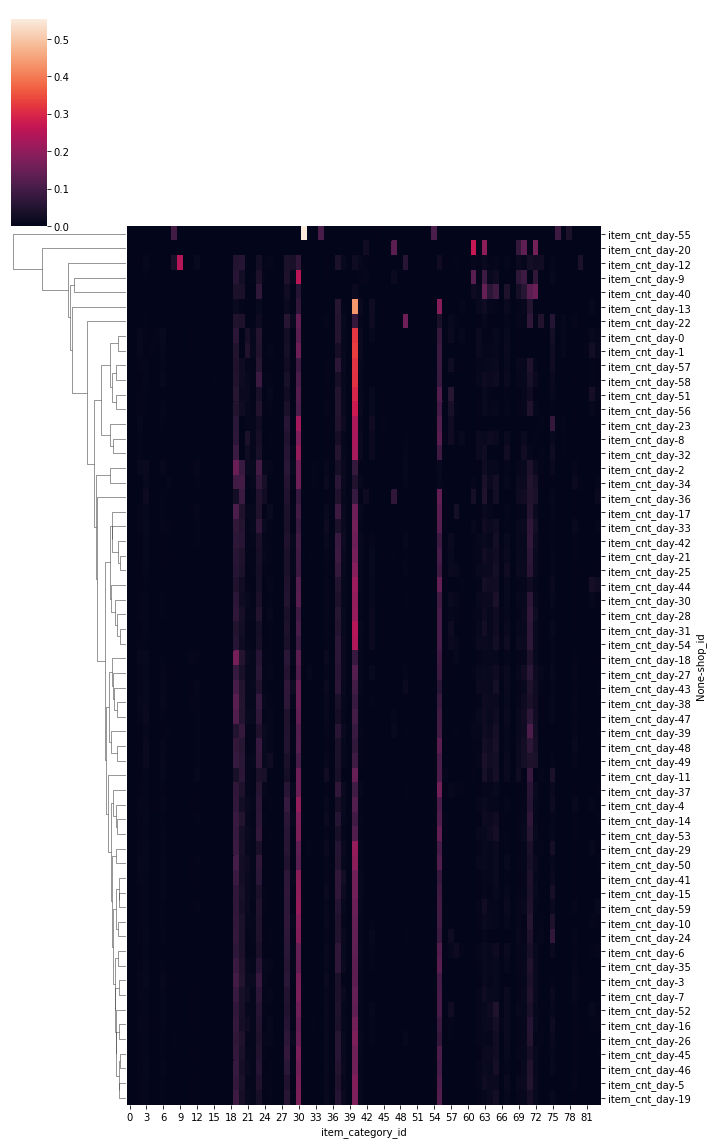

In [ ]:
sb.clustermap(shop_cats_norm.T, col_cluster=False, figsize=(10, 16))

<AxesSubplot:xlabel='item_category_id', ylabel='None-shop_id'>

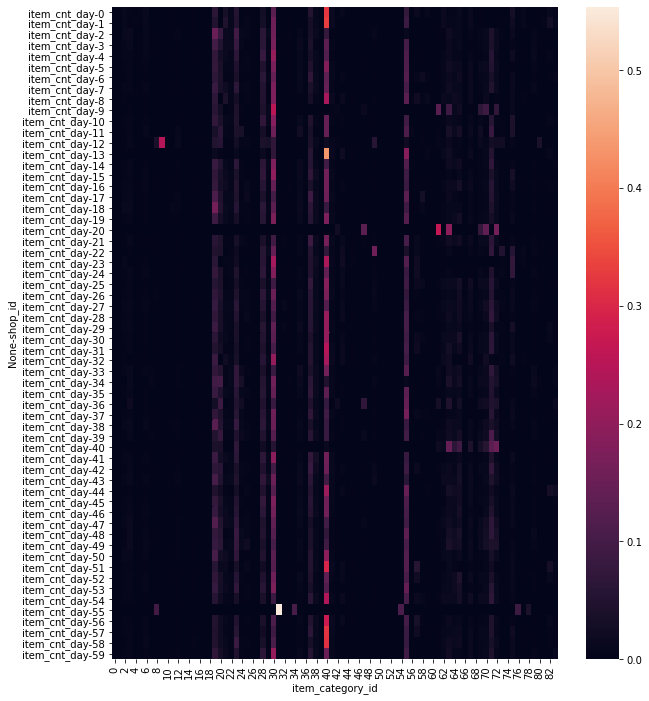

In [ ]:
plt.figure(figsize=(10, 12))
sb.heatmap(shop_cats_norm.T)

In [ ]:
shop_cats_norm

item_cnt_day                                          \
shop_id                    0         1         2         3         4    
item_category_id                                                        
0                    0.000085  0.000000  0.000000  0.000000  0.000000   
1                    0.000085  0.000000  0.000000  0.000000  0.000000   
2                    0.008971  0.009983  0.011594  0.007053  0.007032   
3                    0.004443  0.002852  0.017211  0.012696  0.007578   
4                    0.003246  0.004754  0.001372  0.000987  0.002298   
...                       ...       ...       ...       ...       ...   
79                   0.000000  0.000000  0.007250  0.008887  0.011401   
80                   0.000000  0.000000  0.000000  0.003491  0.000114   
81                   0.003759  0.004437  0.000065  0.000000  0.000705   
82                   0.012473  0.026779  0.002286  0.000000  0.008648   
83                   0.007347  0.010141  0.001666  0.001975  0.001593   

                                                                    ...  \
shop_id                 5         6         7         8         9   ...   
item_category_id                                                    ...   
0                 0.000000  0.000000  0.000000  0.000000  0.000000  ...   
1                 0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2                 0.005425  0.004199  0.007322  0.005285  0.002017  ...   
3                 0.007951  0.007513  0.008262  0.000000  0.004475  ...   
4                 0.000889  0.000209  0.001372  0.000556  0.000000  ...   
...                    ...       ...       ...       ...       ...  ...   
79                0.007226  0.006359  0.010275  0.000278  0.000882  ...   
80                0.000608  0.000617  0.000373  0.000000  0.000000  ...   
81                0.000000  0.000517  0.000000  0.000000  0.000000  ...   
82                0.000000  0.006050  0.000000  0.000000  0.000000  ...   
83                0.002806  0.006896  0.002162  0.000000  0.000000  ...   

                                                                              \
shop_id                 50        51        52        53        54        55   
item_category_id                                                               
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2                 0.009615  0.004737  0.005026  0.005531  0.004704  0.000000   
3                 0.010139  0.005065  0.007559  0.007461  0.005910  0.000000   
4                 0.001207  0.001148  0.001106  0.001103  0.000554  0.000000   
...                    ...       ...       ...       ...       ...       ...   
79                0.002243  0.000000  0.005247  0.005839  0.001787  0.000000   
80                0.000171  0.000000  0.000040  0.000130  0.000000  0.000189   
81                0.000000  0.002235  0.000482  0.000000  0.000275  0.000000   
82                0.000000  0.032255  0.012001  0.000000  0.001652  0.000000   
83                0.005693  0.008387  0.006292  0.002498  0.001787  0.000000   

                                                          
shop_id                 56        57        58        59  
item_category_id                                          
0                 0.000000  0.000000  0.000000  0.000000  
1                 0.000000  0.000000  0.000000  0.000000  
2                 0.004329  0.004741  0.003964  0.004552  
3                 0.006045  0.006839  0.007023  0.008144  
4                 0.000589  0.001056  0.000979  0.001061  
...                    ...       ...       ...       ...  
79                0.002882  0.001665  0.002300  0.007042  
80                0.001037  0.000000  0.000000  0.000612  
81                0.000602  0.000574  0.000440  0.000000  
82                0.010144  0.004451  0.005029  0.000000  
83                0.003484  0.004323  0.003181  0.01090

<AxesSubplot:>

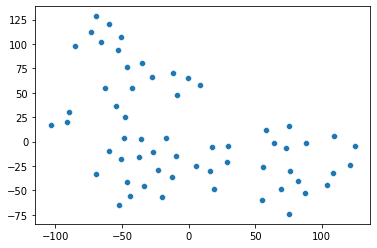

In [ ]:
from sklearn.manifold import TSNE

shop_cats_tsne = TSNE(n_components=2, perplexity=10.0).fit_transform(shop_cats_norm.T)

sb.scatterplot(x=shop_cats_tsne[:,0], y=shop_cats_tsne[:,1])

<AxesSubplot:>

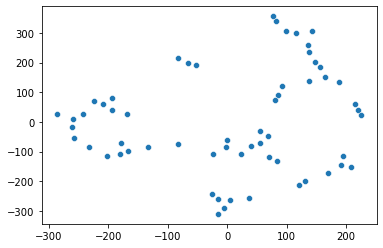

In [ ]:
shops_cats = pd.DataFrame(
    np.array(list(product(*[shops['shop_id'].unique(), cats['item_category_id'].unique()]))),
    columns =['shop_id', 'item_category_id']
)

shops_cats

,shop_id,item_category_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
5035,59,79
5036,59,80
5037,59,81
5038,59,82


In [ ]:
price = train[['item_id', 'item_price']]
price = price.groupby(['item_id'])['item_price'].mean().reset_index()
price

price

,item_id,item_price
0,0,58.000000
1,1,4490.000000
2,2,58.000000
3,3,79.000000
4,4,58.000000
...,...,...
21802,22165,59.000000
21803,22166,150.000000
21804,22167,297.686490
21805,22168,798.916667


In [ ]:
shopprice = train[['shop_id', 'item_id', 'item_price']]
shopprice = shopprice.groupby(['item_id', 'shop_id'])['item_price'].mean().reset_index()
shopprice

,item_id,shop_id,item_price
0,0,54,58.0
1,1,55,4490.0
2,2,54,58.0
3,3,54,79.0
4,4,54,58.0
...,...,...,...
424119,22168,12,799.0
424120,22168,16,799.0
424121,22168,42,799.0
424122,22168,43,798.5


In [ ]:
testtmp = test.merge(shopprice, on=['item_id', 'shop_id'], how='left')
testtmp

,shop_id,item_id,item_price
0,5,5037,1633.692308
1,5,5320,NaN
2,5,5233,865.666667
3,5,5232,599.000000
4,5,5268,NaN
...,...,...,...
214195,45,18454,187.888889
214196,45,16188,NaN
214197,45,15757,199.000000
214198,45,19648,NaN


In [ ]:
testtmp.loc[testtmp['item_price'].isnull(), 'item_price'] = df['Pclass'].map(price.item_price)

In [ ]:
price.head()

,item_id,item_price
0,0,58.0
1,1,4490.0
2,2,58.0
3,3,79.0
4,4,58.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=915d6e57-4e7f-4527-840e-d54ca0b4f460' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>